## Work
1. 請比較使用不同層數以及不同 Dropout rate 對訓練的效果
2. 將 optimizer 改成使用 Adam 並加上適當的 dropout rate 檢視結果

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.
C:\Users\Sean\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Sean\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Sean\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Sean\Anaconda3

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
from keras.layers import Dropout

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

def build_mlp1(input_shape, output_units=10, num_neurons=[512, 256, 256, 128], drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:

"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
Dropout_EXP = [0.15, 0.25, 0.35]

In [8]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for i in range(2):
    for dropout in Dropout_EXP:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        if i == 0:
            model = build_mlp(input_shape=x_train.shape[1:], drp_ratio=dropout)
        else:
            model = build_mlp1(input_shape=x_train.shape[1:], drp_ratio=dropout)
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)
    
        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["accuracy"]
        valid_acc = model.history.history["val_accuracy"]
    
        exp_name_tag = "exp-l2-%d-%s" %(i, str(dropout))
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0   

50000/50000 [==============================] - 3s 59us/step - loss: 1.2004 - accuracy: 0.5726 - val_loss: 1.2966 - val_accuracy: 0.5422
Epoch 46/50
50000/50000 [==============================] - 3s 59us/step - loss: 1.1902 - accuracy: 0.5754 - val_loss: 1.3014 - val_accuracy: 0.5406
Epoch 47/50
50000/50000 [==============================] - 3s 59us/step - loss: 1.1908 - accuracy: 0.5749 - val_loss: 1.2903 - val_accuracy: 0.5411
Epoch 48/50
50000/50000 [==============================] - 3s 59us/step - loss: 1.1780 - accuracy: 0.5797 - val_loss: 1.2920 - val_accuracy: 0.5415
Epoch 49/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.1699 - accuracy: 0.5814 - val_loss: 1.2953 - val_accuracy: 0.5413
Epoch 50/50
50000/50000 [==============================] - 3s 59us/step - loss: 1.1669 - accuracy: 0.5827 - val_loss: 1.2856 - val_accuracy: 0.5431
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape

50000/50000 [==============================] - 3s 60us/step - loss: 1.3489 - accuracy: 0.5186 - val_loss: 1.3425 - val_accuracy: 0.5199
Epoch 41/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.3394 - accuracy: 0.5231 - val_loss: 1.3335 - val_accuracy: 0.5268
Epoch 42/50
50000/50000 [==============================] - 3s 61us/step - loss: 1.3341 - accuracy: 0.5243 - val_loss: 1.3339 - val_accuracy: 0.5231
Epoch 43/50
50000/50000 [==============================] - 3s 61us/step - loss: 1.3278 - accuracy: 0.5258 - val_loss: 1.3389 - val_accuracy: 0.5208
Epoch 44/50
50000/50000 [==============================] - 3s 61us/step - loss: 1.3220 - accuracy: 0.5288 - val_loss: 1.3205 - val_accuracy: 0.5282
Epoch 45/50
50000/50000 [==============================] - 3s 61us/step - loss: 1.3181 - accuracy: 0.5302 - val_loss: 1.3234 - val_accuracy: 0.5288
Epoch 46/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.3019 - accuracy: 0.5351 - val_loss: 1.3242

50000/50000 [==============================] - 3s 62us/step - loss: 1.5018 - accuracy: 0.4660 - val_loss: 1.4306 - val_accuracy: 0.4915
Epoch 36/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.4925 - accuracy: 0.4686 - val_loss: 1.4172 - val_accuracy: 0.4923
Epoch 37/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.4906 - accuracy: 0.4662 - val_loss: 1.4188 - val_accuracy: 0.4936
Epoch 38/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.4798 - accuracy: 0.4708 - val_loss: 1.4029 - val_accuracy: 0.4966
Epoch 39/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.4756 - accuracy: 0.4758 - val_loss: 1.4039 - val_accuracy: 0.5006
Epoch 40/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.4624 - accuracy: 0.4799 - val_loss: 1.3971 - val_accuracy: 0.5051
Epoch 41/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.4629 - accuracy: 0.4795 - val_loss: 1.3951

Epoch 29/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.3479 - accuracy: 0.5198 - val_loss: 1.3584 - val_accuracy: 0.5110
Epoch 30/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.3410 - accuracy: 0.5208 - val_loss: 1.3568 - val_accuracy: 0.5150
Epoch 31/50
50000/50000 [==============================] - 3s 61us/step - loss: 1.3250 - accuracy: 0.5245 - val_loss: 1.3413 - val_accuracy: 0.5190
Epoch 32/50
50000/50000 [==============================] - 3s 61us/step - loss: 1.3196 - accuracy: 0.5271 - val_loss: 1.3392 - val_accuracy: 0.5248
Epoch 33/50
50000/50000 [==============================] - 3s 61us/step - loss: 1.3092 - accuracy: 0.5315 - val_loss: 1.3388 - val_accuracy: 0.5247
Epoch 34/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.3006 - accuracy: 0.5372 - val_loss: 1.3354 - val_accuracy: 0.5233
Epoch 35/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.2882 - accuracy: 0.5377 - val_

Epoch 23/50
50000/50000 [==============================] - 3s 61us/step - loss: 1.5295 - accuracy: 0.4540 - val_loss: 1.4565 - val_accuracy: 0.4803
Epoch 24/50
50000/50000 [==============================] - 3s 61us/step - loss: 1.5204 - accuracy: 0.4551 - val_loss: 1.4466 - val_accuracy: 0.4864
Epoch 25/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.5084 - accuracy: 0.4616 - val_loss: 1.4369 - val_accuracy: 0.4848
Epoch 26/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.5029 - accuracy: 0.4597 - val_loss: 1.4271 - val_accuracy: 0.4870
Epoch 27/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.4917 - accuracy: 0.4670 - val_loss: 1.4323 - val_accuracy: 0.4854
Epoch 28/50
50000/50000 [==============================] - 3s 61us/step - loss: 1.4784 - accuracy: 0.4722 - val_loss: 1.4199 - val_accuracy: 0.4910
Epoch 29/50
50000/50000 [==============================] - 3s 61us/step - loss: 1.4727 - accuracy: 0.4725 - val_

Epoch 17/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.7116 - accuracy: 0.3836 - val_loss: 1.5968 - val_accuracy: 0.4308
Epoch 18/50
50000/50000 [==============================] - 3s 66us/step - loss: 1.6988 - accuracy: 0.3874 - val_loss: 1.5757 - val_accuracy: 0.4394
Epoch 19/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.6879 - accuracy: 0.3912 - val_loss: 1.5555 - val_accuracy: 0.4475
Epoch 20/50
50000/50000 [==============================] - 4s 71us/step - loss: 1.6742 - accuracy: 0.3976 - val_loss: 1.5558 - val_accuracy: 0.4448
Epoch 21/50
50000/50000 [==============================] - 3s 68us/step - loss: 1.6677 - accuracy: 0.3989 - val_loss: 1.5562 - val_accuracy: 0.4511
Epoch 22/50
50000/50000 [==============================] - 3s 61us/step - loss: 1.6545 - accuracy: 0.4033 - val_loss: 1.5343 - val_accuracy: 0.4468
Epoch 23/50
50000/50000 [==============================] - 3s 61us/step - loss: 1.6452 - accuracy: 0.4096 - val_

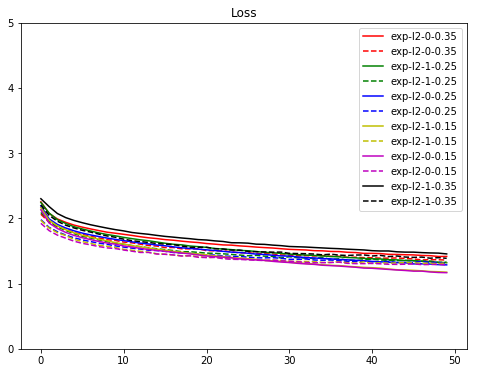

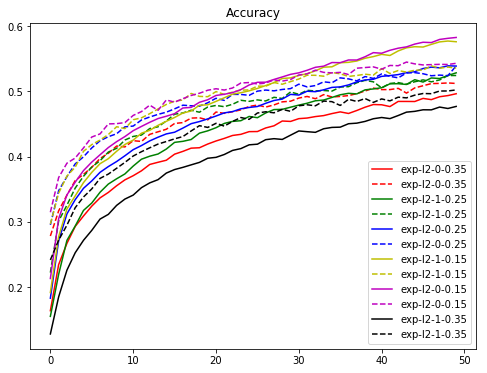

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()